# Segmentación de Clientes para Optimizar Estrategias de Marketing Personalizadas

## 1. Importar Librerías

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 2. Cargar los datos

In [11]:
# Reemplaza el nombre del archivo por el tuyo
df = pd.read_csv("../data/output.csv")

# Ver los primeros registros
df.head()

,passenger_email,total_tickets,avg_spent,days_in_advance_avg,discount_rate,web_rate,last_purchase_days_ago
0,hx.xxx@hotmail.com,49,80.051020,0.0612,0.0,1.0000,93
1,jxxxxxx@icloud.com,42,61.904762,0.1667,0.0,0.0476,145
2,Jxxxxxxxxxxx@gmail.com,38,86.105263,0.9211,0.0,1.0000,104
3,gxxxxxxxxxxxxxxxxx@gmail.com,38,63.815789,0.3684,0.0,0.0000,385
4,exxxxxx_xx@hotmail.com,37,68.243243,3.9459,0.0,0.9730,89


## 3. Descripción de la tabla

| Campo                     | Descripción                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| passenger_id              | Correo único del pasajero (solo para referencia, no se usa en K-Means)|     |
| total_tickets             | Número total de tickets comprados en los últimos 6 meses                    |
| avg_spent                 | Gasto promedio por ticket                                                   |
| days_in_advance_avg       | Promedio de días de anticipación entre la compra y la fecha del viaje       |
| discount_rate             | Proporción de tickets comprados con descuento (0 a 1)                       |
| web_rate                  | Porcentaje de compras realizadas a través de la web                         |
| mobile_rate               | Porcentaje de compras realizadas desde la app móvil                         |
| last_purchase_days_ago    | Días transcurridos desde la última compra hasta hoy                         |
| cluster                   | Etiqueta asignada por el modelo K-Means (0, 1, 2, ...)                      |


In [12]:
# Verificar información del DataFrame
df.describe()

,total_tickets,avg_spent,days_in_advance_avg,discount_rate,web_rate,last_purchase_days_ago
count,18292.000000,18292.000000,18292.000000,18292.0,18292.000000,18292.000000
mean,3.472338,98.288875,4.606713,0.0,0.843784,250.772906
std,2.769072,43.529015,8.132991,0.0,0.343252,111.316765
min,2.000000,5.000000,0.000000,0.0,0.000000,87.000000
25%,2.000000,69.000000,1.000000,0.0,1.000000,163.000000
50%,2.000000,85.000000,2.000000,0.0,1.000000,226.000000
75%,4.000000,117.000000,4.666700,0.0,1.000000,342.000000
max,49.000000,405.000000,112.000000,0.0,1.000000,481.000000


## 4. Escalar datos

In [13]:
# Eliminar columnas innecesarias
df_model = df.drop(columns=['passenger_email'], errors='ignore')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

El escalamiento de datos se aplica porque K-Means agrupa a los clientes según la distancia entre ellos, y si las variables tienen diferentes escalas (por ejemplo, dólares vs. porcentajes), las más grandes dominan el resultado.

Escalar los datos permite que todas las variables tengan el mismo peso, asegurando que el modelo agrupe a los clientes de manera justa y equilibrada, sin que una característica influya más que las demás solo por tener valores numéricos más altos.

## 5. Encontrar número óptimo de clusters

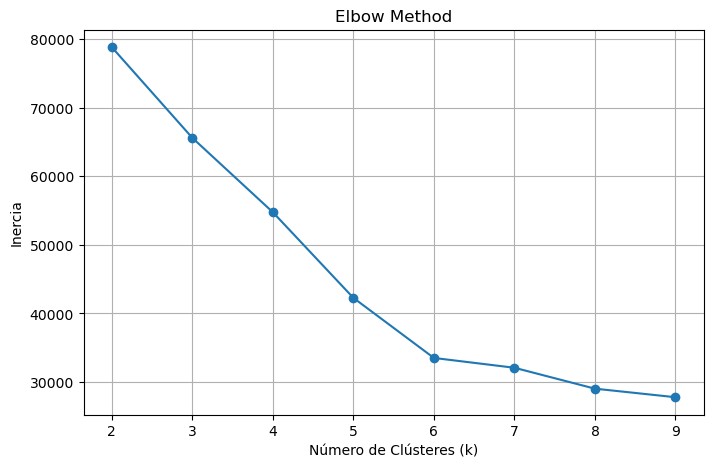

In [14]:
inertia = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Gráfica
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

Se aplicó Elbow Method, el cual evalúa la relación entre el número de clústeres y la inercia del modelo. En el gráfico generado se observó un punto de inflexión en k=3, lo que indica que ese es el número óptimo de agrupamientos. A partir de 3, la reducción adicional de inercia al incrementar los clústeres es mínima, lo cual indica que agregar más grupos no mejora significativamente la segmentación y puede complicar la interpretación. Elegir 3 clústeres permite un equilibrio entre precisión del modelo y claridad en el análisis.

## 6. Entrenar Modelo K-Means

In [15]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

## 7. Evaluación y visualización

Silhouette Score: 0.297


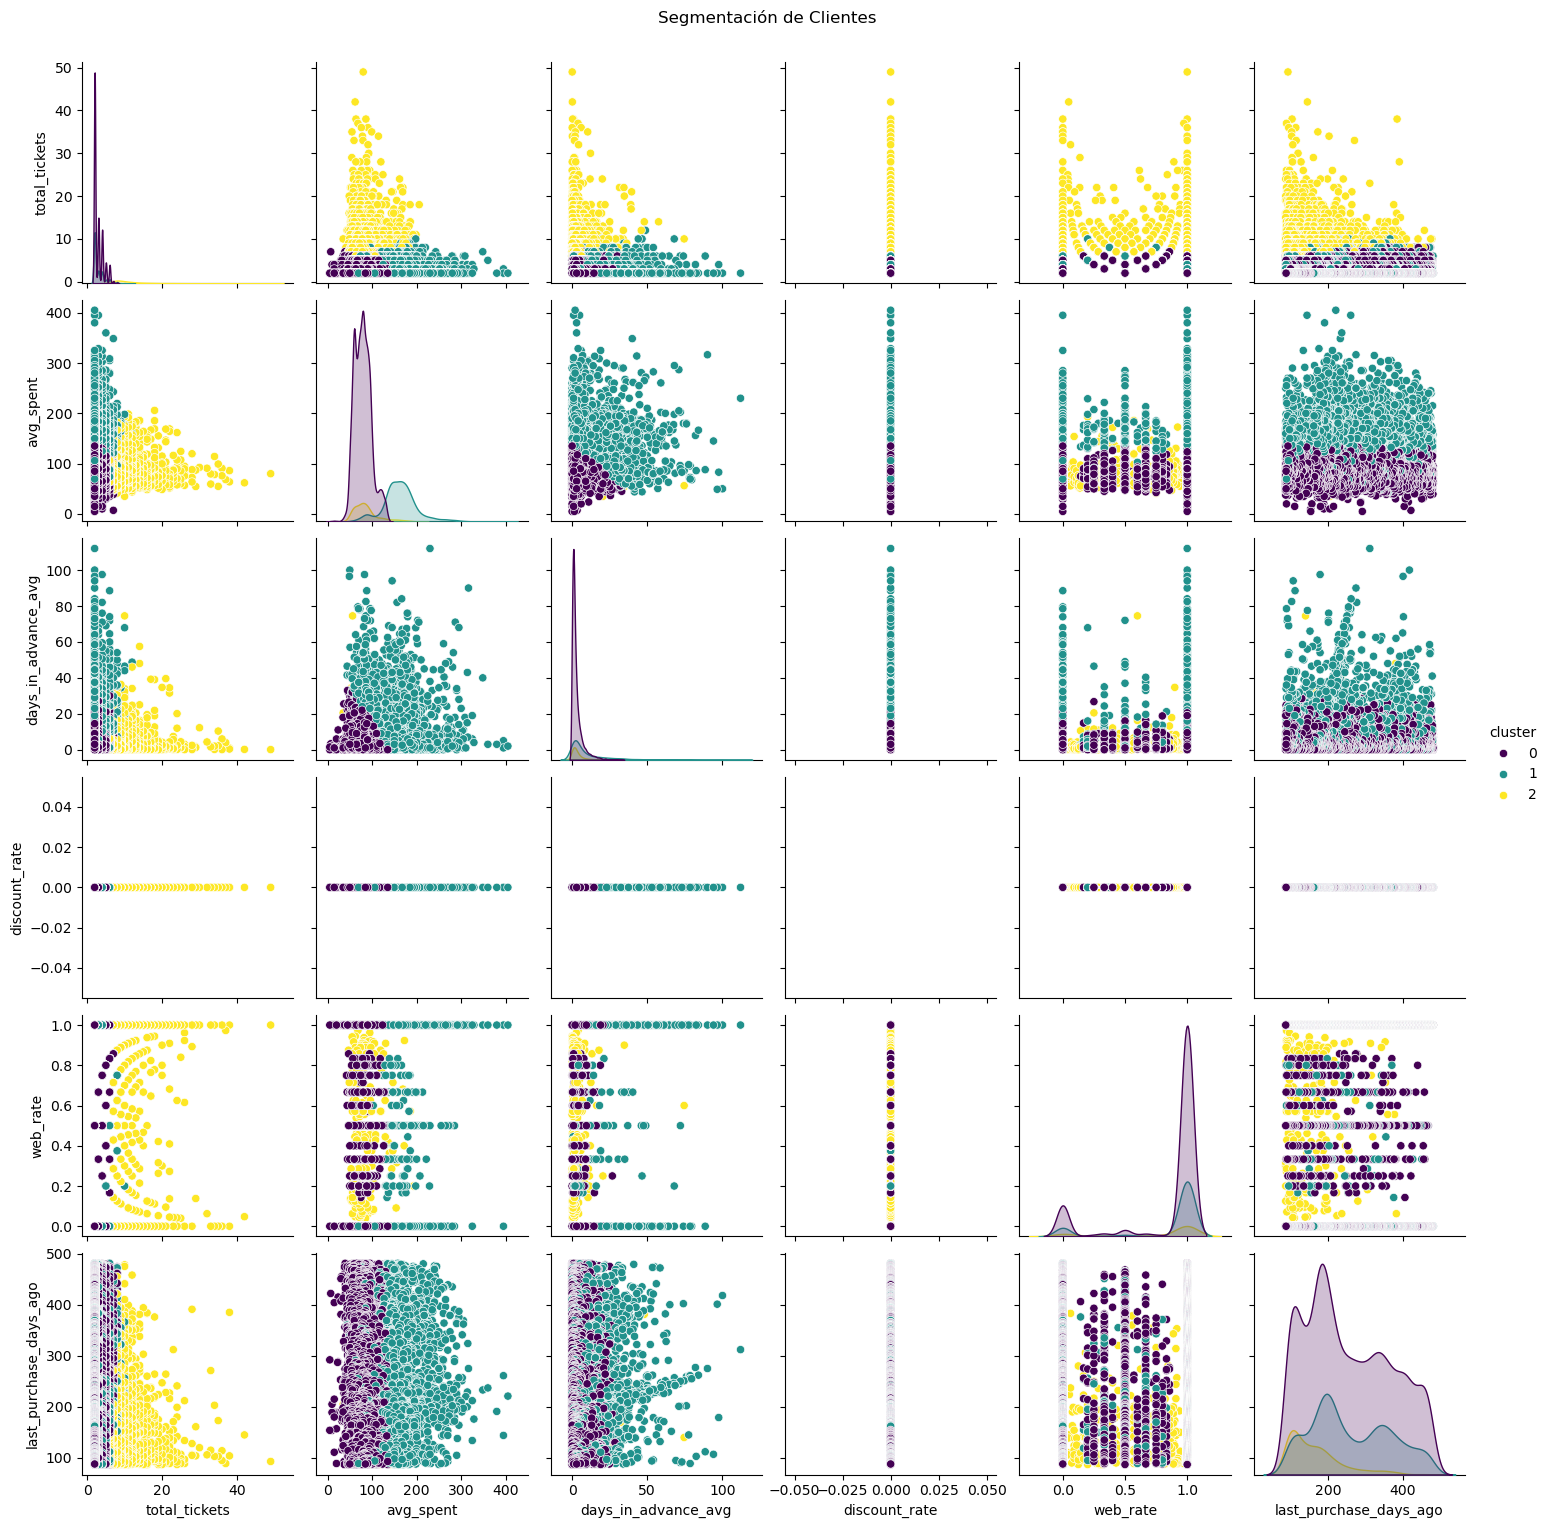

In [16]:
# Score de silueta
score = silhouette_score(X_scaled, df['cluster'])
print(f"Silhouette Score: {score:.3f}")

# Visualización básica en 2D (si usas 2 o 3 variables)
sns.pairplot(df, hue='cluster', palette='viridis')
plt.suptitle('Segmentación de Clientes', y=1.02)
plt.show()

### 🟣 Clúster 0 (púrpura)
- **Frecuencia baja** (`total_tickets` alrededor de 1 a 3).
- **Gasto variable**, con algunos pasajeros gastando hasta más de $300.
- **Alta anticipación promedio** en la compra (`days_in_advance_avg`).
- **Preferencia por canal web** variable, pero tienden a extremos (0 o 1).
- **Compras más recientes** (`last_purchase_days_ago` entre 100 y 300).
---

### 🟢 Clúster 1 (verde)
- **Frecuencia media** en la compra de tickets.
- **Gasto más controlado y consistente**, concentrado entre $80–120.
- **Anticipación más baja** que el clúster púrpura.
- **Uso de canal web** distribuido entre intermedio y bajo.
- **Compras recientes o semi-recientes**.
---

### 🟡 Clúster 2 (amarillo)
- **Frecuencia alta**, con varios pasajeros que compran más de 10 tickets.
- **Gasto promedio más bajo**, pero frecuente.
- **Compra con muy poca anticipación**.
- **Alto uso del canal web**, especialmente valores cercanos a 1.
- **Compras muy recientes**.

### Resumen
- Las variables más efectivas para distinguir clústeres siguen siendo:
  - `total_tickets`
  - `avg_spent`
  - `last_purchase_days_ago`
  - `web_rate`
- La variable `discount_rate` permanece como poco útil: es casi constante y no separa grupos.
- Se confirman **3 segmentos bien definidos**: clientes esporádicos, promedio y frecuentes.

In [17]:
df.groupby('cluster').mean(numeric_only=True)

,total_tickets,avg_spent,days_in_advance_avg,discount_rate,web_rate,last_purchase_days_ago
cluster,,,,,,
0,2.875392,78.474646,2.812978,0.0,0.850585,255.968339
1,2.907901,162.032665,10.214081,0.0,0.847957,261.914564
2,10.982707,86.994258,4.099866,0.0,0.765344,165.727068


## Conclusión

El modelo K-Means permitió identificar tres segmentos clave de pasajeros:

- **Clúster 0**: clientes esporádicos, de bajo gasto y compras recientes; candidatos para campañas de reactivación.
- **Clúster 1**: pasajeros planificadores y de alto gasto, pero inactivos; ideales para promociones exclusivas y fidelización.
- **Clúster 2**: usuarios frecuentes y activos, con gasto moderado; representan el público más valioso para retención.

Estos resultados permiten a Tornado Bus Company personalizar sus estrategias de marketing y mejorar la toma de decisiones comerciales a partir del comportamiento real de sus clientes.